In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape, RepeatVector, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.constraints import unit_norm, max_norm
import tensorflow as tf
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import argparse
import os
from sklearn.manifold import MDS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/drive/MyDrive/MTP_DEC/1_para.csv')

data = pd.DataFrame(data)

In [ ]:
data.head()

,0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,k
0,376.228731,376.105858,375.982985,375.860112,375.737238,375.614365,375.491492,375.368619,375.245746,375.122873,375,162.769570
1,378.621190,378.259071,377.896952,377.534833,377.172714,376.810595,376.448476,376.086357,375.724238,375.362119,375,55.230459
2,376.947473,376.752726,376.557978,376.363231,376.168484,375.973736,375.778989,375.584242,375.389495,375.194747,375,102.697189
3,376.348463,376.213616,376.078770,375.943924,375.809078,375.674231,375.539385,375.404539,375.269693,375.134846,375,148.317051
4,377.804453,377.524008,377.243562,376.963117,376.682672,376.402226,376.121781,375.841336,375.560891,375.280445,375,71.315157


In [ ]:
original_data_x = data.iloc[:,:11]
original_data_x.head()

,0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2
0,376.228731,376.105858,375.982985,375.860112,375.737238,375.614365,375.491492,375.368619,375.245746,375.122873,375
1,378.621190,378.259071,377.896952,377.534833,377.172714,376.810595,376.448476,376.086357,375.724238,375.362119,375
2,376.947473,376.752726,376.557978,376.363231,376.168484,375.973736,375.778989,375.584242,375.389495,375.194747,375
3,376.348463,376.213616,376.078770,375.943924,375.809078,375.674231,375.539385,375.404539,375.269693,375.134846,375
4,377.804453,377.524008,377.243562,376.963117,376.682672,376.402226,376.121781,375.841336,375.560891,375.280445,375


In [ ]:
# Define the standard deviation of the noise
noise_stddev = 0.5 # Adjust this value as needed

# Add random noise to the DataFrame
noise = np.random.normal(0, noise_stddev, size=original_data_x.shape)
original_data_x = original_data_x + noise

In [ ]:
y = data.iloc[:,-1]
y.head()

0    162.769570
1     55.230459
2    102.697189
3    148.317051
4     71.315157
Name: k, dtype: float64

In [ ]:
result = pd.concat([original_data_x, y], axis=1)
result.head()

,0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,k
0,375.531111,376.401210,376.090474,376.156169,375.580507,376.548895,375.458527,375.552408,375.730346,374.736702,374.735096,162.769570
1,378.149432,377.947394,377.774311,378.363725,377.224247,376.577283,376.418201,375.901189,375.687881,374.792807,374.973707,55.230459
2,376.704954,376.645110,376.772039,376.386953,376.959856,376.300799,374.989440,375.644714,375.609122,376.226793,375.323305,102.697189
3,376.397365,375.937388,375.768820,376.350798,375.091415,376.540217,375.364570,376.101966,375.384158,374.441976,375.473724,148.317051
4,378.578761,376.985777,377.377793,376.725877,377.168242,376.397711,376.085437,374.998751,375.488111,375.419574,374.014947,71.315157


In [ ]:
# from sklearn.preprocessing import StandardScaler
# #Create a StandardScaler instance
# scaler = StandardScaler()

# # Standardize the DataFrame and create a new DataFrame
# result = pd.DataFrame(scaler.fit_transform(result), columns=result.columns)

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Normalize the DataFrame and create a new DataFrame
result = pd.DataFrame(scaler.fit_transform(result), columns=result.columns)

print("\nNormalized DataFrame:")
print(result)


Normalized DataFrame:
            0      0.02      0.04      0.06      0.08       0.1      0.12  \
0    0.029444  0.110431  0.094092  0.099965  0.139207  0.213390  0.168990   
1    0.157392  0.196409  0.200125  0.250597  0.259050  0.216094  0.272033   
2    0.086806  0.123993  0.137011  0.115712  0.239774  0.189756  0.118623   
3    0.071775  0.084639  0.073837  0.113245  0.103548  0.212563  0.158901   
4    0.178372  0.142937  0.175156  0.138839  0.254967  0.198988  0.236303   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.054811  0.092893  0.095713  0.117580  0.157506  0.107487  0.080552   
996  0.081955  0.066952  0.133924  0.106752  0.211769  0.082798  0.114857   
997  0.112246  0.134612  0.151339  0.125359  0.216930  0.127770  0.215687   
998  0.046608  0.110574  0.098604  0.102623  0.164220  0.139137  0.179249   
999  0.112081  0.070560  0.087600  0.096831  0.114639  0.110817  0.099402   

         0.14      0.16      0.18       0.2         

In [ ]:
# # Function to normalize a DataFrame and return scaling parameters
# def normalize_dataframe(df):
#     min_max_values = {}
#     normalized_df = df.copy()
#     for column in df.columns:
#         min_value = df[column].min()
#         max_value = df[column].max()
#         min_max_values[column] = (min_value, max_value)
#         normalized_df[column] = (df[column] - min_value) / (max_value - min_value)
#     return normalized_df, min_max_values

# # Normalize the original DataFrame and get scaling parameters
# normalized_df, min_max_values = normalize_dataframe(result)

In [ ]:
result = result.sample(frac=1.0, random_state=101)  # Set a random_state for reproducibility

In [ ]:
x_train = result.iloc[:900,:-1]
x_test = result.iloc[900:,:-1]
x_train.shape, x_test.shape

((900, 11), (100, 11))

In [ ]:
y_train = result.iloc[:900,-1]
y_test = result.iloc[900:,-1]
y_train.shape, y_test.shape

((900,), (100,))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# # Generating synthetic data
# np.random.seed(0)
# x = np.random.rand(100, 1) * 10  # 100 random points
# y = 2 * x + 1 + np.random.randn(100, 1) * 2  # linear relationship with some noise

# Creating a linear regression model
model = LinearRegression()

# Fitting the model
model.fit(x_train, y_train)

# Making predictions
y_pred = model.predict(x_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean squared error:", mse)
print("Coefficient of determination:", r2)

# # Plotting
# # plt.scatter(x_test, y_test, color='black')
# # plt.plot(x, y_pred, color='blue', linewidth=3)
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Linear Regression Example')
# plt.show()

Coefficients: [-0.28713211 -0.4746512  -0.05134778  0.1278303  -0.29223851 -0.11325968
 -0.33860475 -0.07729929  0.06545721 -0.04030789  0.02823733]
Intercept: 0.8065041679861947
Mean squared error: 0.03636151295755359
Coefficient of determination: 0.5257481929541146


In [ ]:
# Load Toy Example Data
training_feature = x_train
ground_truth_r = y_train

testing_feature_sk = x_test
testing_score = y_test

original_dim = training_feature.shape[1]
num_train = training_feature.shape[0]

In [ ]:
## Build VAE-Regression Model
input_shape_x = (original_dim, )
input_shape_r = (1, )

## Build VAE-Regression Model
input_shape_x = (original_dim, )
input_shape_r = (1, )

intermediate_dim_1 = 7
intermediate_dim_2 = 5
intermediate_dim_3 = 3
batch_size = 1
latent_dim = 2
epochs = 20

# VAE model = encoder + decoder
# build encoder model
inputs_r = Input(shape=input_shape_r, name='ground_truth')
inputs_x = Input(shape=input_shape_x, name='encoder_input')
inputs_x_dropout = Dropout(0.25)(inputs_x)

inter_x1 = Dense(intermediate_dim_1, activation='tanh', name='encoder_intermediate_1')(inputs_x_dropout)
inter_x2 = Dense(intermediate_dim_2, activation='tanh', name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(intermediate_dim_3, activation='tanh', name='encoder_intermediate_3')(inter_x2)

# posterior on Y; probablistic regressor
r_mean = Dense(1, name='r_mean')(inter_x3)
r_log_var = Dense(1, name='r_log_var')(inter_x3)

# q(z|x)
z_mean = Dense(latent_dim, name='z_mean')(inter_x3)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x3)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
r = Lambda(sampling, output_shape=(1,), name='r')([r_mean, r_log_var])

# latent generator (simplified)
generator_input = Input(shape=(1,), name='generator_input')
pz_mean = Dense(latent_dim, name='pz_mean',kernel_constraint=unit_norm())(generator_input)
pz_log_var = Dense(1, name='pz_log_var')(generator_input)

# instantiate generator model
generator = Model(generator_input, [pz_mean,pz_log_var], name='generator')
generator.summary()

# instantiate encoder model
encoder = Model([inputs_x,inputs_r], [z_mean, z_log_var, z, r_mean, r_log_var, r], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(intermediate_dim_3, activation='tanh')(latent_inputs)
inter_y2 = Dense(intermediate_dim_2, activation='tanh')(inter_y1)
inter_y3 = Dense(intermediate_dim_1, activation='tanh')(inter_y2)
outputs = Dense(original_dim)(inter_y3)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
pz_mean,pz_log_var = generator(encoder([inputs_x,inputs_r])[5])
outputs = decoder(encoder([inputs_x,inputs_r])[2])
vae = Model([inputs_x,inputs_r], [outputs, pz_mean,pz_log_var], name='vae_mlp')
vae.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 generator_input (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 pz_mean (Dense)             (None, 2)                    4         ['generator_input[0][0]']     
                                                                                                  
 pz_log_var (Dense)          (None, 1)                    2         ['generator_input[0][0]']     
                                                                                                  
Total params: 6 (24.00 Byte)
Trainable params: 6 (24.00 Byte)
Non-trainable params: 0 (0.0

In [ ]:
from tensorflow.keras.optimizers import Adam

##Customize Lost Function of the VAE Model
models = (encoder, decoder)

reconstruction_loss = mse(inputs_x,outputs)
reconstruction_loss = K.abs(reconstruction_loss)

## Modified KL loss
## DKL (q(z, c|x) || p(z, c|x))
kl_loss = 1 + z_log_var - pz_log_var - (K.square(z_mean-pz_mean) / K.exp(pz_log_var)) - (K.exp(z_log_var) / K.exp(pz_log_var))



## KL loss of standard VAE
## DKL(q(zx)| || p(z))
## kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)


kl_loss = -0.5*K.sum(kl_loss, axis=-1)
kl_loss = K.abs(kl_loss)
mse_loss = (0.5*K.square(r_mean - inputs_r) /  K.exp(r_log_var)) +  0.5 * r_log_var
mse_loss = K.abs(mse_loss)

vae_loss = K.mean(reconstruction_loss+kl_loss+mse_loss)

vae.add_loss(K.abs(vae_loss))
optimizer = Adam(learning_rate=0.01)  # Adjust the learning rate value as needed
vae.compile(optimizer=optimizer)
vae.summary()
vae.save_weights('random_weights.h5')

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 11)]                 0         []                            
                                                                                                  
 ground_truth (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  166       ['encoder_input[0][0]',       
                              (None, 2),                             'ground_truth[0][0]',        
                              (None, 2),                             'encoder_input[0][0]',       
                              (None, 1),                             'ground_truth[0][0]']  

In [ ]:
# Train the VAE model with validation data
history = vae.fit([x_train, y_train],  # Training data
                  epochs=epochs,
                  batch_size=batch_size)  # Validation data)

Epoch 1/20
900/900 [==============================] - 8s 4ms/step - loss: 0.3965
Epoch 2/20
900/900 [==============================] - 3s 3ms/step - loss: 0.1029
Epoch 3/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0646
Epoch 4/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0524
Epoch 5/20
900/900 [==============================] - 4s 4ms/step - loss: 0.0479
Epoch 6/20
900/900 [==============================] - 4s 4ms/step - loss: 0.0442
Epoch 7/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0422
Epoch 8/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0418
Epoch 9/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0403
Epoch 10/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0400
Epoch 11/20
900/900 [==============================] - 4s 5ms/step - loss: 0.0394
Epoch 12/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0403
Epoch 13/20
900/900 [====

In [ ]:
[z_mean, z_log_var, z, r_mean, r_log_var, r] = encoder.predict([x_train,y_train],batch_size=batch_size)

800/800 [==============================] - 1s 2ms/step


Mean squared error: 0.020
R2 Variance score: 0.755


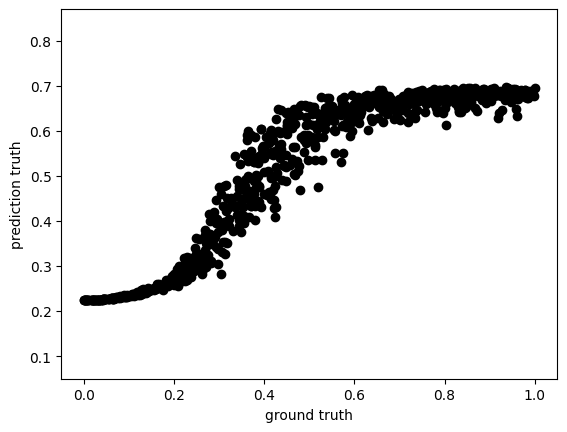

In [ ]:
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_train, r_mean))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(y_train, r_mean))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(y_train, r_mean,  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction truth')
ax.axis('equal');

In [ ]:
[z_mean_t, z_log_var_t, z_t, r_mean_t, r_log_var_t, r_t] = encoder.predict([x_test,y_test],batch_size=batch_size)

200/200 [==============================] - 0s 2ms/step


Mean squared error: 0.020
R2 Variance score: 0.748


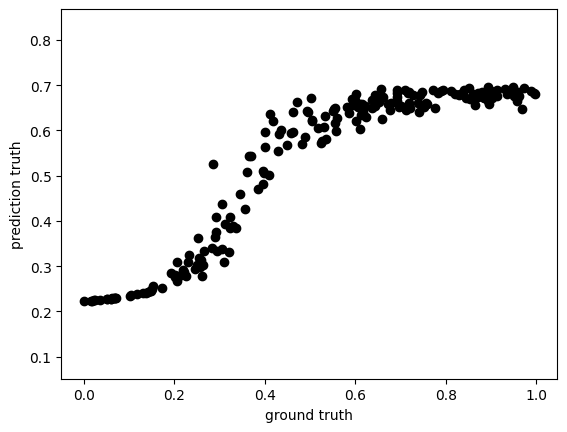

In [ ]:
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test, r_mean_t))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(y_test, r_mean_t))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(y_test, r_mean_t,  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction truth')
ax.axis('equal');

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'result' is your DataFrame containing the data

# Define the number of splits (folds) for cross-validation
num_splits = 5  # You can adjust this as needed

# Initialize KFold cross-validation splitter
kf = KFold(n_splits=num_splits, shuffle=True, random_state=11)

# Initialize lists to store RMSE and R2 scores
rmse_scores = []
r2_scores = []

rmse_scores_train = []
r2_scores_train = []

# Iterate over the splits
for train_idx, test_idx in kf.split(result):
    # Split the data into training and testing sets for this fold
    train_data = result.iloc[train_idx]
    test_data = result.iloc[test_idx]

    x_train = train_data.iloc[:, :-1]
    y_train = train_data.iloc[:, -1]

    x_test = test_data.iloc[:, :-1]
    y_test = test_data.iloc[:, -1]

    # Train the VAE model (assuming 'vae' is already defined)
    history = vae.fit([x_train, y_train], epochs=epochs, batch_size=batch_size, verbose=0)

    # Predict and evaluate on the training set
    [z_mean, z_log_var, z, r_mean, r_log_var, r] = encoder.predict([x_train, y_train], batch_size=batch_size)
    rmse_train = np.sqrt(mean_squared_error(y_train, r_mean))
    r2_train = r2_score(y_train, r_mean)

    # Predict and evaluate on the test set
    [z_mean_t, z_log_var_t, z_t, r_mean_t, r_log_var_t, r_t] = encoder.predict([x_test, y_test], batch_size=batch_size)
    rmse_test = np.sqrt(mean_squared_error(y_test, r_mean_t))
    r2_test = r2_score(y_test, r_mean_t)

    # Append RMSE and R2 scores for this fold
    rmse_scores_train.append(rmse_train)
    r2_scores_train.append(r2_train)

    # Append RMSE and R2 scores for this fold
    rmse_scores.append(rmse_test)
    r2_scores.append(r2_test)

# Calculate the average RMSE and R2 scores across all folds
average_rmse = np.mean(rmse_scores)
average_r2 = np.mean(r2_scores)

average_rmse_train = np.mean(rmse_scores_train)
average_r2_train = np.mean(r2_scores_train)

print(f'Average RMSE: {average_rmse}')
print(f'Average R2 score: {average_r2}')

print(f'Average RMSE_train: {average_rmse_train}')
print(f'Average R2 score_train: {average_r2_train}')

200/200 [==============================] - 1s 2ms/step
Average RMSE: 0.1513855429525339
Average R2 score: 0.7133061939499121
Average RMSE_train: 0.14856057886678545
Average R2 score_train: 0.7268684636103548


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(-0.05623967975199406,
 0.0427292272192531,
 -0.2965922616516977,
 0.49188114566074614)

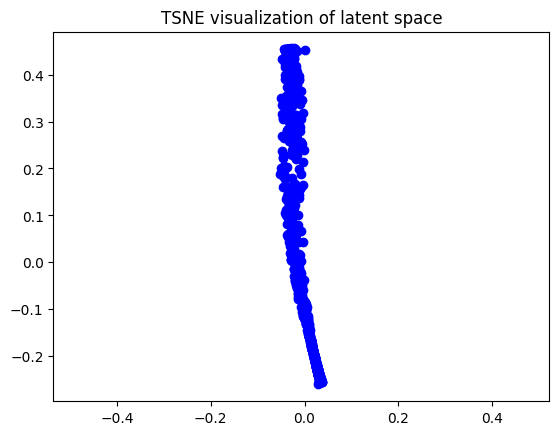

In [ ]:
## Visualize Latent Space
# vae.load_weights('random_weights.h5')
# vae.fit([training_feature,ground_truth_r],
#          epochs=epochs,
#          batch_size=batch_size,
#          verbose = 0)

# [z_mean, z_log_var, z, r_mean, r_log_var, r] = encoder.predict([training_feature,ground_truth_r],batch_size=batch_size)

tsne = MDS(n_components=2, random_state=0)
X_2d = tsne.fit_transform(z_mean)

#%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c='blue')
plt.title('TSNE visualization of latent space')
ax.axis('equal')

In [ ]:
r2_train

0.7874945319169885

In [ ]:
x_test

,0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2
464,0.087618,0.088591,0.145835,0.120307,0.093452,0.107450,0.119245,0.159606,0.066979,0.485007,0.612996
374,0.127846,0.170122,0.208024,0.178975,0.159785,0.260666,0.240217,0.303049,0.300059,0.149832,0.485276
641,0.467356,0.432152,0.463628,0.454689,0.487086,0.533631,0.498753,0.439731,0.358101,0.568053,0.346285
340,0.317420,0.289243,0.335048,0.289080,0.299892,0.281710,0.440427,0.410454,0.412935,0.433219,0.529059
309,0.052186,0.025220,0.114201,0.135481,0.089197,0.210722,0.142731,0.296798,0.330932,0.308230,0.777637
...,...,...,...,...,...,...,...,...,...,...,...
900,0.096463,0.092506,0.110408,0.112188,0.166378,0.173953,0.116024,0.261216,0.256510,0.375848,0.474045
637,0.060173,0.056475,0.123147,0.100942,0.084395,0.137959,0.166138,0.047915,0.239698,0.300079,0.685031
688,0.079537,0.165552,0.160908,0.133333,0.170611,0.269721,0.294988,0.301741,0.165455,0.352874,0.702779
951,0.096751,0.055271,0.150712,0.097705,0.158491,0.145294,0.074434,0.220777,0.171543,0.310519,0.623059


In [ ]:
y_test

464    0.884189
374    0.313240
641    0.059795
340    0.137958
309    0.897217
         ...   
900    0.494226
637    0.717876
688    0.398006
951    0.593692
91     0.306842
Name: k, Length: 200, dtype: float64

In [ ]:
# train original data
y_train_np = y_train.to_numpy().reshape(-1, 1)
concatenated_data_train = np.concatenate((x_train, y_train_np), axis=1)
original_data_restored_train = scaler.inverse_transform(concatenated_data_train)
original_data_restored_train.shape

(800, 12)

In [ ]:
# test original data
y_test_np = y_test.to_numpy().reshape(-1, 1)
concatenated_data_test = np.concatenate((x_test, y_test_np), axis=1)
original_data_restored_test = scaler.inverse_transform(concatenated_data_test)
original_data_restored_test.shape

(200, 12)

In [ ]:
# Use the decoder to generate predictions
predictions_train = decoder.predict(z)
predictions_test = decoder.predict(z_t)

7/7 [==============================] - 0s 3ms/step


In [ ]:
# train decoded data
decoded_data_train = np.concatenate((predictions_train, r_mean), axis=1)
decoded_data_train_rescaled = scaler.inverse_transform(decoded_data_train)
decoded_data_train_rescaled.shape

(800, 12)

In [ ]:
# train decoded data
decoded_data_test = np.concatenate((predictions_test, r_mean_t), axis=1)
decoded_data_test_rescaled = scaler.inverse_transform(decoded_data_test)
decoded_data_test_rescaled.shape

(200, 12)

Mean squared error: 712.752
R2 Variance score: 0.755


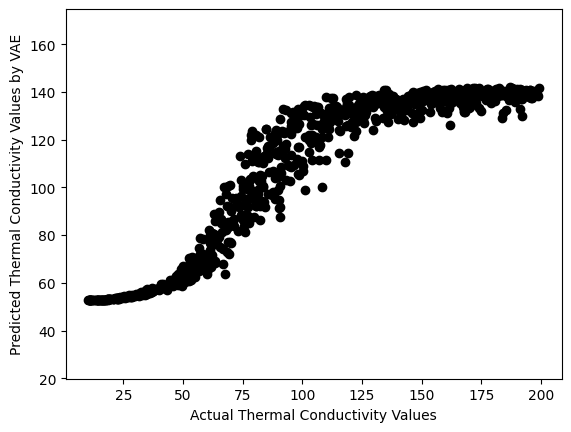

In [ ]:
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(original_data_restored_train[:,-1], decoded_data_train_rescaled[:,-1]))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(original_data_restored_train[:,-1], decoded_data_train_rescaled[:,-1]))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(original_data_restored_train[:,-1], decoded_data_train_rescaled[:,-1],  color='black')
plt.xlabel('Actual Thermal Conductivity Values')
plt.ylabel('Predicted Thermal Conductivity Values by VAE')
ax.axis('equal');

Mean squared error: 705.323
R2 Variance score: 0.748


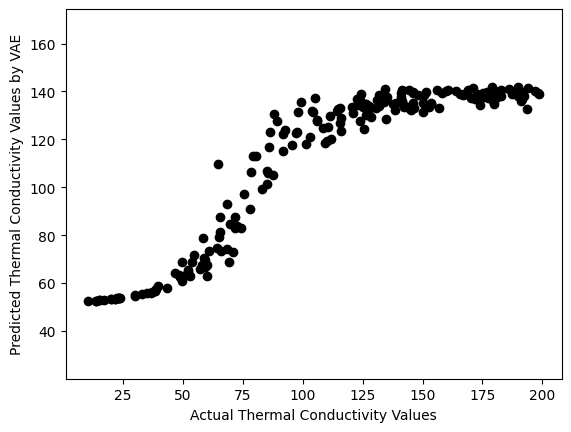

In [ ]:
## Test Data
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(original_data_restored_test[:,-1], decoded_data_test_rescaled[:,-1]))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(original_data_restored_test[:,-1], decoded_data_test_rescaled[:,-1]))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(original_data_restored_test[:,-1], decoded_data_test_rescaled[:,-1],  color='black')
plt.xlabel('Actual Thermal Conductivity Values')
plt.ylabel('Predicted Thermal Conductivity Values by VAE')
ax.axis('equal');

In [ ]:
std_deviation_r_t = np.sqrt(np.exp(r_log_var_t / 2.0))
std_deviation_r_t[:5]

array([[0.9975098 ],
       [0.99764675],
       [0.9974796 ],
       [0.99763787],
       [0.99752754]], dtype=float32)

In [ ]:
r_mean_t = pd.DataFrame(r_mean_t)

In [ ]:
op = pd.concat([x_test, r_mean_t], axis=1)

In [ ]:
import pandas as pd

# Function to reverse the normalization
def reverse_normalize(df, min_max_values):
    original_df = df.copy()
    for column, (min_value, max_value) in min_max_values.items():
        original_df[column] = (df[column] * (max_value - min_value)) + min_value
    return original_df

# Reverse the normalization using the computed scaling parameters
original_df_restored = reverse_normalize(op, min_max_values)

print("\nRestored DataFrame:")
print(original_df_restored)


NameError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Problem Parameters
q = 1000
L = 0.2
TL = 93.429
sig_m = 0.1
x = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2])
T = np.array([104.6, 103.48, 102.48, 101.57, 100.75, 100, 99.36, 98.77, 98.23, 97.75, 93.429])
Nm = len(x)

# Priors
mu_k = 18
sigma_k = 0.05 * mu_k

kmin = 17.5
kmax = 18.5
Ns = 5
ks = np.linspace(kmin, kmax, Ns)

Tsim = np.zeros((Ns, Nm))
P1 = np.zeros(Ns)
P2 = np.zeros(Ns)
P3a = np.zeros(Ns)

for i in range(Ns):
    Tsim[i, :] = -q / ks[i] * x + q * L / ks[i] + TL
    e = Tsim[i, :] - T
    A = np.sum(e**2)
    B = (ks[i] - mu_k)**2 / sigma_k**2
    S = A + B
    P1[i] = np.exp(-0.5 * S / sig_m**2)
    P2[i] = ks[i] * P1[i]
    P3a[i] = ks[i]**2 * P1[i]

Den = np.sum(P1)
PPDF = P1 / Den
km = np.sum(P2) / Den
vark = np.sum(P3a) / Den - km**2
sq = np.sqrt(vark)

plt.plot(ks, PPDF, '-')
plt.xlabel('k')
plt.ylabel('PPDF')
plt.show()

## Only VAE

In [ ]:
## Build VAE-Regression Model
input_shape_x = (original_dim, )
# input_shape_r = (1, )

## Build VAE-Regression Model
input_shape_x = (original_dim, )
# input_shape_r = (1, )

intermediate_dim_1 = 7
intermediate_dim_2 = 5
intermediate_dim_3 = 3
batch_size = 1
latent_dim = 2
epochs = 20

# VAE model = encoder + decoder
# build encoder model
# inputs_r = Input(shape=input_shape_r, name='ground_truth')
inputs_x = Input(shape=input_shape_x, name='encoder_input')
inputs_x_dropout = Dropout(0.25)(inputs_x)

inter_x1 = Dense(intermediate_dim_1, activation='tanh', name='encoder_intermediate_1')(inputs_x_dropout)
inter_x2 = Dense(intermediate_dim_2, activation='tanh', name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(intermediate_dim_3, activation='tanh', name='encoder_intermediate_3')(inter_x2)

# # posterior on Y; probablistic regressor
# r_mean = Dense(1, name='r_mean')(inter_x3)
# r_log_var = Dense(1, name='r_log_var')(inter_x3)

# q(z|x)
z_mean = Dense(latent_dim, name='z_mean')(inter_x3)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x3)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# r = Lambda(sampling, output_shape=(1,), name='r')([r_mean, r_log_var])

# # latent generator (simplified)
# generator_input = Input(shape=(1,), name='generator_input')
# pz_mean = Dense(latent_dim, name='pz_mean',kernel_constraint=unit_norm())(generator_input)
# pz_log_var = Dense(1, name='pz_log_var')(generator_input)

# # instantiate generator model
# generator = Model(generator_input, [pz_mean,pz_log_var], name='generator')
# generator.summary()

# instantiate encoder model
encoder = Model([inputs_x], [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(intermediate_dim_3, activation='tanh')(latent_inputs)
inter_y2 = Dense(intermediate_dim_2, activation='tanh')(inter_y1)
inter_y3 = Dense(intermediate_dim_1, activation='tanh')(inter_y2)
outputs = Dense(original_dim)(inter_y3)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# # instantiate VAE model
# pz_mean,pz_log_var = generator(encoder([inputs_x,inputs_r])[5])
outputs = decoder(encoder([inputs_x])[2])
vae = Model([inputs_x], [outputs], name='vae_mlp')
vae.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam

##Customize Lost Function of the VAE Model
models = (encoder, decoder)

reconstruction_loss = mse(inputs_x,outputs)
reconstruction_loss = K.abs(reconstruction_loss)

# ## Modified KL loss
# ## DKL (q(z, c|x) || p(z, c|x))
# kl_loss = 1 + z_log_var - pz_log_var - (K.square(z_mean-pz_mean) / K.exp(pz_log_var)) - (K.exp(z_log_var) / K.exp(pz_log_var))



## KL loss of standard VAE
## DKL(q(zx)| || p(z))
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)


kl_loss = -0.5*K.sum(kl_loss, axis=-1)
kl_loss = K.abs(kl_loss)
# mse_loss = (0.5*K.square(r_mean - inputs_r) /  K.exp(r_log_var)) +  0.5 * r_log_var
# mse_loss = K.abs(mse_loss)

vae_loss = K.mean(reconstruction_loss+kl_loss)

vae.add_loss(K.abs(vae_loss))
optimizer = Adam(learning_rate=0.01)  # Adjust the learning rate value as needed
vae.compile(optimizer=optimizer)
vae.summary()
vae.save_weights('random_weights.h5')

In [ ]:
# Train the VAE model with validation data
history = vae.fit([x_train],  # Training data
                  epochs=epochs,
                  batch_size=batch_size)  # Validation data)

In [ ]:
[z_mean, z_log_var, z] = encoder.predict(x_train,batch_size=batch_size)

In [ ]:
tsne = MDS(n_components=2, random_state=0)
X_2d = tsne.fit_transform(z_mean)

#%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c='blue')
plt.title('TSNE visualization of latent space')
ax.axis('equal')